In [2]:
import os
import torch
from torchvision import transforms
from  torchvision.ops import box_iou
from util.augmentations import Compose
from util.data_aug import *
from transform import MyBoxScaleTransform
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import torchvision
from util.actions_tree import Actor
import torch.nn.functional as F
from models.mnist_scale_model import Net, Agent
from datasets.clutter_mnist_scale_rl import MNIST_CoLoc
from RL import get_policy_loss
import matplotlib.ticker as ticker

os.environ['CUDA_VISIBLE_DEVICES']='3'

In [3]:
def init_dataloader():
    kwargs = {'num_workers': 8, 'pin_memory': True}

    train_transform = Compose([Resize(84)])
    test_transform = Compose([Resize(84)])
    trainset = MNIST_CoLoc(root='.', train=True, digit=4,
                           datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                           clutter=1, transform=train_transform,
                           target_transform=MyBoxScaleTransform(num=1))
    testset = MNIST_CoLoc(root='.', train=False, digit=4,
                          datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                          clutter=1, transform=test_transform,
                          target_transform=MyBoxScaleTransform(num=1))

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=512, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=512, shuffle=False, **kwargs)
    print('total train image: ', len(train_loader.dataset), ' test image: ',
          len(test_loader.dataset))
    return train_loader, test_loader

In [4]:
def init_model(hidden_size, freeze=1):
    net = Net(pooling_size=7,
              pooling_mode='align').to(device)
    agent = Agent(dim=1024, num_class=10,
                  hidden_size=hidden_size).to(device)
    # if load pretrained encoder
    pretrained = 'cluttermnist_m60_trip_SGD_scale_newsmp/best.pth.tar'
    ckpt = torch.load(os.path.join('/research/cbim/vast/tl601/results/'
                      'selfpaced/ordinal/',
                      pretrained))
    net.load_state_dict(ckpt['state_dict'])
    print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                ckpt['epoch'], ckpt['acc']))
    if freeze == 1:
        for name, value in net.named_parameters():
            value.requires_grad = False

    return net, agent


In [5]:
hidden_size = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = init_dataloader()
model, agent = init_model(hidden_size=hidden_size)

# load model 
savename = 'coloc_rl_sparse_seq10_scale'
saveroot = '/research/cbim/vast/tl601/results/selfpaced/ordinal/'
model_path = os.path.join(saveroot, savename, 'best.pth.tar')
print('loading ckpt from ', model_path)
ckpt = torch.load(model_path)
state_dict = ckpt['state_dict']
epoch = ckpt['epoch']
best_loss = ckpt['acc']
agent.load_state_dict(state_dict)
print(("=> loaded checkpoint epoch {} {}".format(epoch, best_loss)))

total train image:  5842  test image:  982
loaded from cluttermnist_m60_trip_SGD_scale_newsmp/best.pth.tar
ckpt epoch 24 acc 91.85%
loading ckpt from  /research/cbim/vast/tl601/results/selfpaced/ordinal/coloc_rl_sparse_seq10_scale_ent1/best.pth.tar
=> loaded checkpoint epoch 88 84.01222229003906


In [10]:
# generate positive or negative boundbing boxes with fixed size 28*28 or random size
FG_THRESH = 0.7
BG_THRESH = 0.5
MAX_ASPECT_RATIO = 6.00
MIN_ASPECT_RATIO = 0.15
def generate_random_rois_noscale(img_h, img_w, boxes, num, pos=True):
    all_new_boxes = []

    for j, box in enumerate(boxes.cpu()):
        new_boxes = []
        for i in range(num):
            done = False
            while not done:
                width, height = 28, 28
                x = np.random.randint(0, img_w-width)
                y = np.random.randint(0, img_h-height)
                #print('x ', x, ' y ', y)
                x1, y1, x2, y2 = max(x, 0), max(0, y), \
                                min(img_w - 1, x + width-1), min(img_h - 1, y + height-1)
                iou = box_iou(box.view(-1, 4),
                              torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32))
                if pos:
                    if iou > BG_THRESH:
                        done = True
                        break
                else:
                    if iou < BG_THRESH:
                        done = True
                        break
            new_boxes.append(np.array([x1, y1, x2, y2]))

        #print(j, ' ', len(new_boxes))
        assert (len(new_boxes) == num)
        all_new_boxes += new_boxes

    all_new_boxes = np.stack(all_new_boxes)
    all_new_boxes = torch.from_numpy(all_new_boxes).view(boxes.shape[0], -1, 4).float()
    return all_new_boxes

def generate_random_rois_scale(img_h, img_w, boxes, num, min_box_side=28, pos=False):
    """
        generate new negative rois with random size
        :param img: tensor, (bs, c, h, w)
        :param boxes: tensor, (bs, 4)
        :param num: number of new boxes
        :return: tensor, (bs, num, 5) new boxes (x1, y1, x2, y2)
        """
    all_new_boxes = []

    for j, box in enumerate(boxes.cpu()):

        new_boxes = []
        for i in range(num):
            done = False
            while not done:
                width = np.random.randint(min_box_side, img_w + 1)  
                height = width
                
                # centered in image
                x = np.random.randint(0, img_w+1-width)
                y = np.random.randint(0, img_h+1-height)
                x1, y1, x2, y2 = max(x, 0), max(0, y), \
                                 min(img_w - 1, x + width-1), min(img_h - 1, y + height-1)
                iou = box_iou(box.view(-1, 4),
                              torch.tensor([[x1, y1, x2, y2]], dtype=torch.float32))
                if not pos:
                    if iou < BG_THRESH:
                        done = True
                else:
                    if iou > BG_THRESH:
                        done = True
            new_boxes.append(np.array([x1, y1, x2, y2]))

        #print(j, ' ', len(new_boxes))
        assert (len(new_boxes) == num)
        all_new_boxes += new_boxes

    all_new_boxes = np.stack(all_new_boxes)
    all_new_boxes = torch.from_numpy(all_new_boxes).view(boxes.shape[0], -1, 4).float()
    return all_new_boxes

In [11]:
# calculate reward according to accuracy
accs, rewards = [], []
with torch.no_grad():
    model.eval()
    for i in range(1,100):
        for batch_idx, (data_org, target_org, _, _) in enumerate(train_loader):
            batch_size = data_org.shape[0]
#             if batch_size < 512: 
#                 continue
            data_org, target_org = data_org.to(device), target_org.to(device).float()
            org_boxes = torch.tensor([[0, 0, 112, 112]]).float().repeat(batch_size, 1).to(device)
            # randomly sample i% correct boxes, 1-i% negative boxes
            num_pos = int(batch_size * i / 100.)
            inds = np.random.permutation(batch_size)
            inds_pos, inds_neg = inds[:num_pos], inds[num_pos:]
            pred_boxes = torch.empty(batch_size, 4).to(device)
            rois_pos = generate_random_rois_scale(84, 84, target_org[inds_pos], 
                                             num=1, pos=True)
            pred_boxes[inds_pos] = rois_pos.view(-1, 4).to(device)
            #pred_boxes[inds_pos] = target_org[inds_pos, :-1]

            rois_neg = generate_random_rois_scale(84, 84, target_org[inds_neg], num=1,
                                           pos=False)
            pred_boxes[inds_neg] = rois_neg.view(-1, 4).to(device)
        
            # last iteration
            rois_t = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                      target_org.to(device)), dim=1)
            rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                      pred_boxes.to(device)), dim=1)
            embed_t = model(data_org, rois_t)
            embed = model(data_org, rois)
            reward = F.pairwise_distance(embed_t, embed)
            
            
            accs.append(float(num_pos) / batch_size)
            rewards.append(reward.mean().item())
            break
print('accs ', accs[:10])
print('rewards ', rewards[:10])

accs  [0.009765625, 0.01953125, 0.029296875, 0.0390625, 0.048828125, 0.05859375, 0.068359375, 0.078125, 0.08984375, 0.099609375]
rewards  [417.8387451171875, 414.1728515625, 416.2804260253906, 414.00543212890625, 411.227294921875, 410.979736328125, 408.2130432128906, 409.95782470703125, 390.99395751953125, 388.1650390625]


Text(0, 0.5, 'distance')

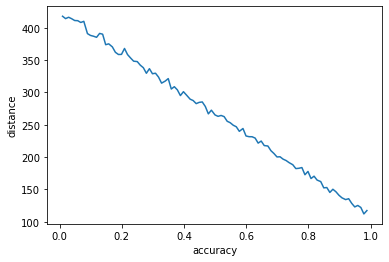

In [12]:
fig = plt.figure()
ax = plt.axes()
ax.plot(accs, rewards)
ax.set_xlabel('accuracy')
ax.set_ylabel('distance')